In [62]:
import joblib

bundle1 = joblib.load("../../saved-models/merged/merged_hgb.pkl")
hgb_model = bundle1["model"]
hgb_thr = bundle1.get("threshold", 0.5)

bundle2 = joblib.load("../../saved-models/merged/merged_knn.pkl")
knn_model = bundle2["model"]
knn_thr = bundle2.get("threshold", 0.5)

rf = joblib.load("../../saved-models/merged/optimal_rf.pkl")
svc= joblib.load("../../saved-models/merged/optimal_svc.pkl")

from pathlib import Path

ARTS = Path("../../saved-models/merged")
ARTS.mkdir(parents=True, exist_ok=True)

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def plot_metrics_vs_threshold(y_true, y_proba, title="Metrics vs Threshold"):
    thresholds = np.linspace(0.0, 1.0, 501)
    accs, precs, recs, f1s = [], [], [], []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        accs.append(accuracy_score(y_true, y_pred))
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred, zero_division=0))
        f1s.append(f1_score(y_true, y_pred, zero_division=0))

    plt.figure(figsize=(8,5))
    plt.plot(thresholds, accs, label="Accuracy")
    plt.plot(thresholds, precs, label="Precision")
    plt.plot(thresholds, recs, label="Recall")
    plt.plot(thresholds, f1s, label="F1")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [64]:
import pandas as pd 
from sklearn.linear_model import LogisticRegression

X_train = pd.read_csv("../../datasets/merged/X_train_imputed_scaled.csv", index_col=0)
X_test = pd.read_csv("../../datasets/merged/X_test_imputed_scaled.csv",  index_col=0)
y_train = pd.read_csv("../../datasets/merged/y_train.csv", index_col=0)["label"]
y_test = pd.read_csv("../../datasets/merged/y_test.csv",  index_col=0)["label"]
groups = pd.read_csv("../../datasets/merged/groups.csv", index_col=0)["star_key"]

meta_base = LogisticRegression() 

param_grid = {
    "solver": ["lbfgs"],
    "penalty": ["l2"],
    "C": [1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3, 1.0],
    "class_weight": [None, "balanced"],
    "max_iter": [5000],
    "tol": [1e-4],
}

In [65]:
from sklearn.model_selection import GroupKFold
import numpy as np 

gkf = GroupKFold(n_splits=5)
splits = list(gkf.split(X_train, y_train, groups=groups))

bases_1 = [("hgb", hgb_model), ("rf", rf)]
Z_train_1 = np.zeros((X_train.shape[0], len(bases_1))) 

In [66]:
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV

for m, (name, model) in enumerate(bases_1): 
    oof = np.zeros(X_train.shape[0])
    for training, test in splits:
        mdl = clone(model)          
        mdl.fit(X_train.iloc[training], y_train.iloc[training])
        oof[test] = mdl.predict_proba(X_train.iloc[test])[:, 1]
    Z_train_1[:, m] = oof

grid_meta = RandomizedSearchCV(
    estimator=meta_base,
    param_distributions=param_grid,
    scoring="average_precision",
    cv=splits,      
    n_jobs=-1,
    refit=True,
    verbose=1
)

Z_test = np.column_stack([
    clone(model).fit(X_train, y_train).predict_proba(X_test)[:, 1]
    for _, model in bases_1
])

grid_meta.fit(Z_train_1, y_train) 
best_model = grid_meta.best_estimator_  
print("Best PR-AUC:", grid_meta.best_score_)
print("Best best params:", grid_meta.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best PR-AUC: 0.9272006481629012
Best best params: {'tol': 0.0001, 'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': 'balanced', 'C': 1.0}


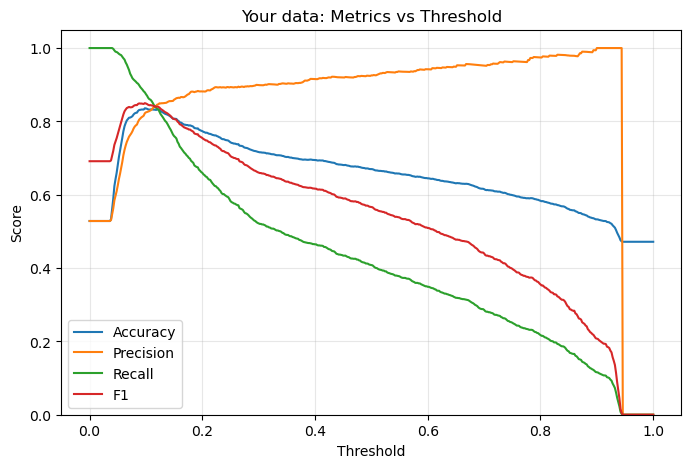

In [67]:
y = best_model.predict_proba(Z_test)[:, 1]

plot_metrics_vs_threshold(y_test, y, title="Your data: Metrics vs Threshold")

In [68]:
from sklearn.metrics import confusion_matrix

meta_prob = best_model.predict_proba(Z_test)[:, 1]

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (meta_prob >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if f1 >= 0.80]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None, None

print(f"Chosen threshold: {thr_star:.3f}  (F1 >= 0.80)")
y_pred_thr = (meta_prob >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.060  (F1 >= 0.80)
Precision/Recall/F1 @ thr: 0.7079646017699115 0.9721229449606862 0.8192771084337349
[[ 688  561]
 [  39 1360]]


In [69]:
bundle_a = {
    "model": best_model,            
    "threshold": thr_star,              
}

joblib.dump(bundle_a, ARTS / "merged_Stack_1.pkl")
print("Saved →", ARTS / "merged_Stack_1.pkl")

Saved → ../../saved-models/merged/merged_Stack_1.pkl


In [70]:
from sklearn.model_selection import GroupKFold
import numpy as np 

gkf = GroupKFold(n_splits=5)
splits = list(gkf.split(X_train, y_train, groups=groups))

bases_2 = [("knn", knn_model), ("rf", rf)]
Z_train_2 = np.zeros((X_train.shape[0], len(bases_2))) 

In [71]:
for m, (name, model) in enumerate(bases_2): 
    oof = np.zeros(X_train.shape[0])
    for training, test in splits:
        mdl = clone(model)          
        mdl.fit(X_train.iloc[training], y_train.iloc[training])
        oof[test] = mdl.predict_proba(X_train.iloc[test])[:, 1]
    Z_train_2[:, m] = oof

grid_meta_2 = RandomizedSearchCV(
    estimator=meta_base,
    param_distributions=param_grid,
    scoring="average_precision",
    cv=splits,      
    n_jobs=-1,
    refit=True,
    verbose=1
)

Z_test_2 = np.column_stack([
    clone(model).fit(X_train, y_train).predict_proba(X_test)[:, 1]
    for _, model in bases_2
])

grid_meta_2.fit(Z_train_2, y_train) 
best_model_2 = grid_meta_2.best_estimator_  
print("Best PR-AUC:", grid_meta_2.best_score_)
print("Best best params:", grid_meta_2.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best PR-AUC: 0.9215671912536649
Best best params: {'tol': 0.0001, 'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': 'balanced', 'C': 0.3}


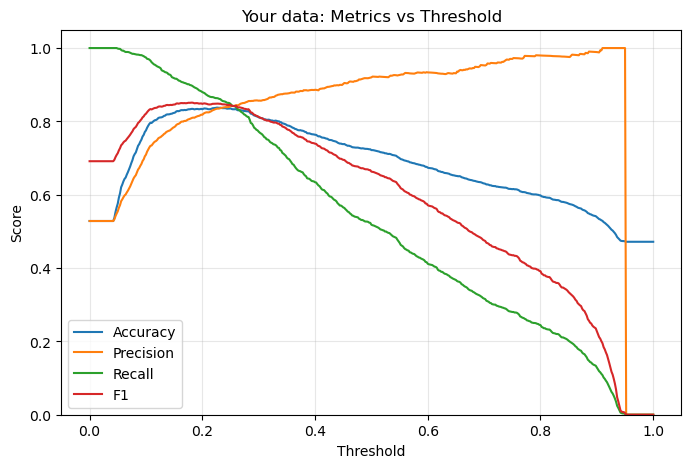

In [72]:
y_2 = best_model_2.predict_proba(Z_test_2)[:, 1]

plot_metrics_vs_threshold(y_test, y_2, title="Your data: Metrics vs Threshold")

In [73]:
meta_prob_2 = best_model_2.predict_proba(Z_test_2)[:, 1]

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (meta_prob_2 >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if f1 >= 0.80]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None, None

print(f"Chosen threshold: {thr_star:.3f}  (F1 >= 0.80)")
y_pred_thr = (meta_prob_2 >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.090  (F1 >= 0.80)
Precision/Recall/F1 @ thr: 0.6788718456209797 0.9807005003573981 0.8023391812865497
[[ 600  649]
 [  27 1372]]


In [74]:
bundle_b = {
    "model": best_model_2,            
    "threshold": thr_star,              
}

joblib.dump(bundle_b, ARTS / "merged_Stack_BEST.pkl")
print("Saved →", ARTS / "merged_Stack_BEST.pkl")

Saved → ../../saved-models/merged/merged_Stack_BEST.pkl


In [75]:
gkf = GroupKFold(n_splits=5)
splits = list(gkf.split(X_train, y_train, groups=groups))

bases_3 = [("knn", knn_model), ("rf", rf), ("hgb", hgb_model)]
Z_train_3 = np.zeros((X_train.shape[0], len(bases_3))) 

In [76]:
for m, (name, model) in enumerate(bases_3): 
    oof = np.zeros(X_train.shape[0])
    for training, test in splits:
        mdl = clone(model)          
        mdl.fit(X_train.iloc[training], y_train.iloc[training])
        oof[test] = mdl.predict_proba(X_train.iloc[test])[:, 1]
    Z_train_3[:, m] = oof

grid_meta_3 = RandomizedSearchCV(
    estimator=meta_base,
    param_distributions=param_grid,
    scoring="average_precision",
    cv=splits,      
    n_jobs=-1,
    refit=True,
    verbose=1
)

Z_test_3 = np.column_stack([
    clone(model).fit(X_train, y_train).predict_proba(X_test)[:, 1]
    for _, model in bases_3
])

grid_meta_3.fit(Z_train_3, y_train) 
best_model_3 = grid_meta_3.best_estimator_  
print("Best PR-AUC:", grid_meta_3.best_score_)
print("Best best params:", grid_meta_3.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best PR-AUC: 0.9272212915778113
Best best params: {'tol': 0.0001, 'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': None, 'C': 1.0}


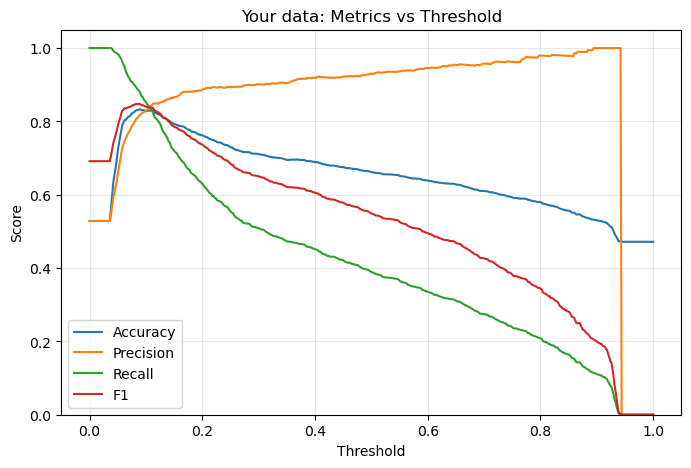

In [77]:
y_3 = best_model_3.predict_proba(Z_test_3)[:, 1]

plot_metrics_vs_threshold(y_test, y_3, title="Your data: Metrics vs Threshold")

In [78]:
meta_prob_3 = best_model_3.predict_proba(Z_test_3)[:, 1]

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (meta_prob_3 >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if f1 >= 0.80]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None, None

print(f"Chosen threshold: {thr_star:.3f}  (F1 >= 0.80)")
y_pred_thr = (meta_prob_3 >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.060  (F1 >= 0.80)
Precision/Recall/F1 @ thr: 0.7373068432671082 0.9549678341672623 0.8321395203986297
[[ 773  476]
 [  63 1336]]


In [79]:
bundle_c = {
    "model": best_model_3,            
    "threshold": thr_star,              
}

joblib.dump(bundle_c, ARTS / "merged_Stack_3.pkl")
print("Saved →", ARTS / "merged_Stack_3.pkl")

Saved → ../../saved-models/merged/merged_Stack_3.pkl


In [80]:
gkf = GroupKFold(n_splits=5)
splits = list(gkf.split(X_train, y_train, groups=groups))

bases_4 = [("hgb", hgb_model), ("svc", svc)]
Z_train_4 = np.zeros((X_train.shape[0], len(bases_4))) 

In [81]:
for m, (name, model) in enumerate(bases_4): 
    oof = np.zeros(X_train.shape[0])
    for training, test in splits:
        mdl = clone(model)          
        mdl.fit(X_train.iloc[training], y_train.iloc[training])
        oof[test] = mdl.predict_proba(X_train.iloc[test])[:, 1]
    Z_train_4[:, m] = oof

meta_base_4 = LogisticRegression() 

param_grid = {
    "solver": ["lbfgs"],
    "penalty": ["l2"],
    "C": [1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3, 1.0],
    "class_weight": [None, "balanced"],
    "max_iter": [5000],
    "tol": [1e-4],
}

grid_meta_4 = RandomizedSearchCV(
    estimator=meta_base_4,
    param_distributions=param_grid,
    scoring="average_precision",
    cv=splits,      
    n_jobs=-1,
    refit=True,
    verbose=1
)

Z_test_4 = np.column_stack([
    clone(model).fit(X_train, y_train).predict_proba(X_test)[:, 1]
    for _, model in bases_4
])

grid_meta_4.fit(Z_train_4, y_train) 
best_model_4 = grid_meta_4.best_estimator_  
print("Best PR-AUC:", grid_meta_4.best_score_)
print("Best best params:", grid_meta_4.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best PR-AUC: 0.9258806472921677
Best best params: {'tol': 0.0001, 'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': 'balanced', 'C': 0.3}


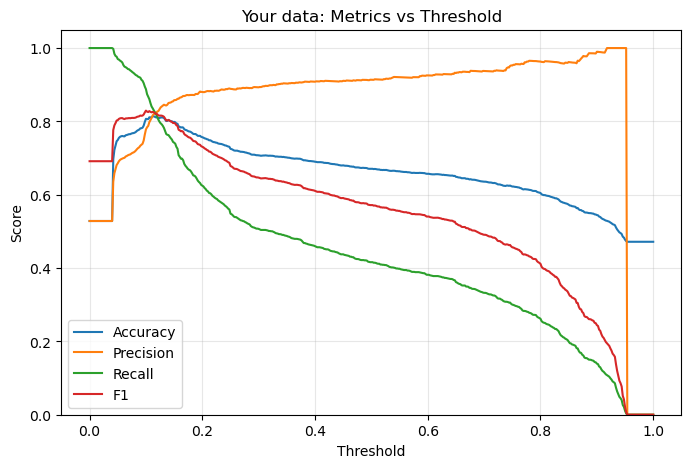

In [82]:
y_4 = best_model_4.predict_proba(Z_test_4)[:, 1]

plot_metrics_vs_threshold(y_test, y_4, title="Your data: Metrics vs Threshold")

In [83]:
meta_prob_4 = best_model_4.predict_proba(Z_test_4)[:, 1]

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (meta_prob_4 >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if f1 >= 0.80]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None, None

print(f"Chosen threshold: {thr_star:.3f}  (F1 >= 0.80)")
y_pred_thr = (meta_prob_4 >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.050  (F1 >= 0.80)
Precision/Recall/F1 @ thr: 0.685699848408287 0.9699785561115082 0.8034339846062759
[[ 627  622]
 [  42 1357]]


In [84]:
bundle_d = {
    "model": best_model_4,            
    "threshold": thr_star,              
}

joblib.dump(bundle_d, ARTS / "merged_Stack_4.pkl")
print("Saved →", ARTS / "merged_Stack_4.pkl")

Saved → ../../saved-models/merged/merged_Stack_4.pkl


In [85]:
import sys
print(sys.executable)
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "skorch"])

/Users/janma/miniconda3/bin/python


0

In [86]:
import torch, pprint
device = "cuda" if torch.cuda.is_available() else "cpu"
ckpt = torch.load("../../saved-models/nn/neural_network_01.pth", map_location=device)
print(type(ckpt))
if isinstance(ckpt, dict):
    print("dict keys:", list(ckpt.keys())[:20])
elif isinstance(ckpt, list):
    print("list length:", len(ckpt))
    print("elem[0] type:", type(ckpt[0]))
    if isinstance(ckpt[0], dict):
        print("elem[0] keys:", list(ckpt[0].keys())[:20])
else:
    print(ckpt)


<class 'list'>
list length: 4
elem[0] type: <class 'collections.OrderedDict'>
elem[0] keys: ['layers.0.weight', 'layers.0.bias', 'layers.2.weight', 'layers.2.bias', 'layers.4.weight', 'layers.4.bias', 'layers.6.weight', 'layers.6.bias']


/var/folders/x0/x7cf__n51m5g22m9ltzp4k4h0000gn/T/ipykernel_32765/3397964354.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("../../saved-models/nn/neur

In [87]:
class MyNet(nn.Module):
    def __init__(self, in_dim, h1, h2=None, h3=None, out_dim=2):
        super().__init__()
        layers = []
        layers += [nn.Linear(in_dim, h1), nn.ReLU()]
        if h2 is not None:
            layers += [nn.Linear(h1, h2), nn.ReLU()]
            if h3 is not None:
                layers += [nn.Linear(h2, h3), nn.ReLU(), nn.Linear(h3, out_dim)]
            else:
                layers += [nn.Linear(h2, out_dim)]
        else:
            layers += [nn.Linear(h1, out_dim)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x): return self.layers(x)


In [88]:
import torch
from collections import OrderedDict

device = "cuda" if torch.cuda.is_available() else "cpu"
ckpt = torch.load("../../saved-models/nn/neural_network_01.pth", map_location=device)
sd = ckpt[0] if isinstance(ckpt, list) else ckpt

# optional: strip 'module.' prefix
if list(sd.keys())[0].startswith("module."):
    sd = OrderedDict((k[7:], v) for k, v in sd.items())

in_dim = sd["layers.0.weight"].shape[1]
h1     = sd["layers.0.weight"].shape[0]
has_h2 = "layers.2.weight" in sd
h2     = sd["layers.2.weight"].shape[0] if has_h2 else None
has_h3 = "layers.4.weight" in sd
h3     = sd["layers.4.weight"].shape[0] if has_h3 else None
out_dim = sd["layers.6.weight"].shape[0] if has_h3 else sd["layers.4.weight"].shape[0]

model = MyNet(in_dim, h1, h2, h3, out_dim).to(device)
model.load_state_dict(sd, strict=True)
model.eval()


/var/folders/x0/x7cf__n51m5g22m9ltzp4k4h0000gn/T/ipykernel_32765/184923171.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("../../saved-models/nn/neura

MyNet(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [89]:
class TorchClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X=None, y=None):
        self.model_ = MyNet(self.in_dim, self.h1, self.h2, self.h3, self.out_dim).to(self.device)
        # load state_dict as above...
        return self
    
    def __init__(self,
                 weights_path,
                 in_dim, h1, h2=None, h3=None, out_dim=2,
                 device=None, batch_size=1024):
        self.weights_path = weights_path
        self.in_dim = in_dim
        self.h1, self.h2, self.h3 = h1, h2, h3
        self.out_dim = out_dim
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size

    @torch.no_grad()
    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float32)
        outs = []
        for i in range(0, len(X), self.batch_size):
            xb = torch.from_numpy(X[i:i+self.batch_size]).to(self.device)
            logits = self.model_(xb)
            if logits.shape[1] == 2:
                p = torch.softmax(logits, dim=1)              # (B,2)
            else:
                p1 = torch.sigmoid(logits).view(-1, 1)        # (B,1)
                p = torch.hstack([1 - p1, p1])                # (B,2)
            outs.append(p.cpu().numpy())
        return np.vstack(outs)

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)



In [106]:
in_dim  = X_train.shape[1]
h1, h2, h3 = 64, 64, 64          # <-- put your actual hidden sizes
out_dim = 2

nn_base = TorchClassifier(
    weights_path="../../saved-models/nn/neural_network_01.pth",
    in_dim=in_dim, h1=h1, h2=h2, h3=h3, out_dim=out_dim,
    device="cuda" if torch.cuda.is_available() else "cpu",
    batch_size=1024,
).fit()

In [107]:
from pathlib import Path
import joblib

ARTS = Path("../../saved-models/merged")
ARTS.mkdir(parents=True, exist_ok=True)

In [108]:
bundle = {
    "model": nn_base,            
    "threshold": 0.5,              
}

joblib.dump(bundle, ARTS / "merged_nn.pkl")
print("Saved →", ARTS / "merged_nn.pkl")

Saved → ../../saved-models/merged/merged_nn.pkl


In [91]:
gkf = GroupKFold(n_splits=5)
splits = list(gkf.split(X_train, y_train, groups=groups))

bases_5 = [("hgb", hgb_model), ("rf", rf), ("nn", nn_base)]
Z_train_5 = np.zeros((X_train.shape[0], len(bases_5))) 

In [92]:
for m, (name, model) in enumerate(bases_5): 
    oof = np.zeros(X_train.shape[0])
    for training, test in splits:
        mdl = clone(model)          
        mdl.fit(X_train.iloc[training], y_train.iloc[training])
        oof[test] = mdl.predict_proba(X_train.iloc[test])[:, 1]
    Z_train_5[:, m] = oof

grid_meta_5 = RandomizedSearchCV(
    estimator=meta_base,
    param_distributions=param_grid,
    scoring="average_precision",
    cv=splits,      
    n_jobs=-1,
    refit=True,
    verbose=1
)

Z_test_5 = np.column_stack([
    clone(model).fit(X_train, y_train).predict_proba(X_test)[:, 1]
    for _, model in bases_5
])

grid_meta_5.fit(Z_train_5, y_train) 
best_model_5 = grid_meta_5.best_estimator_  
print("Best PR-AUC:", grid_meta_5.best_score_)
print("Best best params:", grid_meta_5.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best PR-AUC: 0.9272627001955456
Best best params: {'tol': 0.0001, 'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': None, 'C': 1.0}


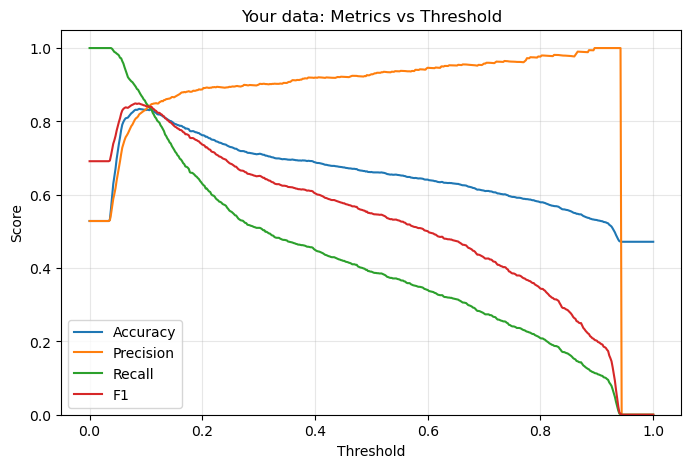

In [93]:
y_5 = best_model_5.predict_proba(Z_test_5)[:, 1]

plot_metrics_vs_threshold(y_test, y_5, title="Your data: Metrics vs Threshold")

In [94]:
meta_prob_5 = best_model_5.predict_proba(Z_test_5)[:, 1]

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (meta_prob_5 >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if f1 >= 0.80]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None, None

print(f"Chosen threshold: {thr_star:.3f}  (F1 >= 0.80)")
y_pred_thr = (meta_prob_5 >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.060  (F1 >= 0.80)
Precision/Recall/F1 @ thr: 0.7386990077177509 0.9578270192994996 0.8341114223467164
[[ 775  474]
 [  59 1340]]


In [95]:
bundle_e = {
    "model": best_model_5,            
    "threshold": thr_star,              
}

joblib.dump(bundle_e, ARTS / "merged_Stack_5.pkl")
print("Saved →", ARTS / "merged_Stack_5.pkl")

Saved → ../../saved-models/merged/merged_Stack_5.pkl


In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score
)

def plot_cm_and_pr(y_true, y_proba, threshold=0.5, title="Model"):
    """
    y_true  : array-like (n,), binary labels {0,1}
    y_proba : array-like (n,), predicted probabilities for the positive class
    threshold : float in [0,1] to convert probabilities to hard labels
    title   : str, used in plot titles/legend
    """
    y_true  = np.asarray(y_true).astype(int)
    y_proba = np.asarray(y_proba).astype(float)
    y_pred  = (y_proba >= threshold).astype(int)

    # --- Confusion matrices ---
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(ax=ax[0], colorbar=False)
    ax[0].set_title(f"{title} — Confusion Matrix (θ={threshold:.2f})")
    ax[0].grid(False)

    cm_norm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true")
    ConfusionMatrixDisplay(cm_norm, display_labels=[0, 1]).plot(ax=ax[1], colorbar=False)
    ax[1].set_title(f"{title} — Confusion Matrix (Normalized)")
    ax[1].grid(False)

    plt.tight_layout()
    plt.show()

    # --- Precision–Recall curve & PR-AUC ---
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    baseline = y_true.mean()  # positive rate

    plot = plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, lw=2, label=f"{title} (AP={ap:.3f})")
    plt.hlines(baseline, 0, 1, colors="gray", linestyles="--",
               label=f"Baseline (pos rate={baseline:.3f})", alpha=0.7)
    plt.xlim(0, 1); plt.ylim(0, 1.01)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title} — Precision–Recall Curve")
    plt.grid(True, linestyle=":")
    plt.legend()
    plt.show()

    print(f"PR-AUC (Average Precision): {ap:.4f}")

    return ax[0], plot, ap


Our stacked model correctly identifies 1372 planets and 600 non-planets. It identified 27 planets as non-planets and 649 non-planets as planets. This 
Precision-Recall curve shows that the model maintains high precision averaged over all recall levels 

In [101]:
gkf = GroupKFold(n_splits=5)
splits = list(gkf.split(X_train, y_train, groups=groups))

bases_6 = [("rf", rf), ("nn", nn_base)]
Z_train_6 = np.zeros((X_train.shape[0], len(bases_6))) 

In [102]:
for m, (name, model) in enumerate(bases_6): 
    oof = np.zeros(X_train.shape[0])
    for training, test in splits:
        mdl = clone(model)          
        mdl.fit(X_train.iloc[training], y_train.iloc[training])
        oof[test] = mdl.predict_proba(X_train.iloc[test])[:, 1]
    Z_train_6[:, m] = oof

grid_meta_6 = RandomizedSearchCV(
    estimator=meta_base,
    param_distributions=param_grid,
    scoring="average_precision",
    cv=splits,      
    n_jobs=-1,
    refit=True,
    verbose=1
)

Z_test_6 = np.column_stack([
    clone(model).fit(X_train, y_train).predict_proba(X_test)[:, 1]
    for _, model in bases_6
])

grid_meta_6.fit(Z_train_6, y_train) 
best_model_6 = grid_meta_6.best_estimator_  
print("Best PR-AUC:", grid_meta_6.best_score_)
print("Best best params:", grid_meta_6.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best PR-AUC: 0.9217232386668155
Best best params: {'tol': 0.0001, 'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': None, 'C': 0.03}


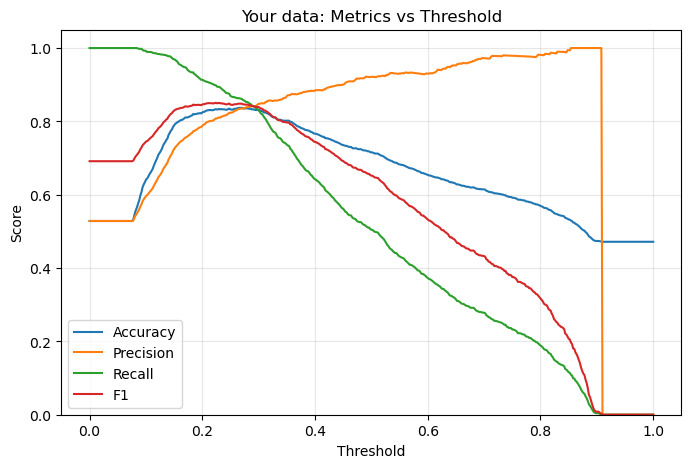

In [103]:
y_6 = best_model_6.predict_proba(Z_test_6)[:, 1]

plot_metrics_vs_threshold(y_test, y_6, title="Your data: Metrics vs Threshold")

In [105]:
bundle_f = {
    "model": best_model_6,            
    "threshold": thr_star,              
}

joblib.dump(bundle_f, ARTS / "merged_Stack_FINAL.pkl")
print("Saved →", ARTS / "merged_Stack_FINAL.pkl")

Saved → ../../saved-models/merged/merged_Stack_FINAL.pkl
